In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data.dataset as Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import opt_einsum as oe

from torch.optim.lr_scheduler import CosineAnnealingLR



transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=50, shuffle=True)
valloader = DataLoader(valset, batch_size=50, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
from models import Finetune_v
from collections import OrderedDict
from finetune import restore_checkpoint

# fmt: off
config = OrderedDict(
    dataset="Cifar10",
    model="vit",
    load_checkpoint_file=None,
    no_cuda=False,

    # === OPTIMIZER ===
    optimizer_learning_rate=1e-3,
    optimizer_warmup_ratio=0.05,  # period of linear increase for lr scheduler
    optimizer_betas=(0.9, 0.95), 
    optimizer_weight_decay=1e-4,
    batch_size=100,
    num_epochs=800,
    seed=42,

    # === Encoder & Decoder ===
    encoder_model_dim = 256,
    encoder_layers = 6,

    decoder_model_dim = 128,
    decoder_layers = 6,
    droprate = 0.1,

    # === MHSA ===
    num_heads = 8,
    encoder_mlp_dim = 512,
    decoder_mlp_dim = 384,
    attn_droprate = 0,
    mlp_droprate = 0.1,
    
    # === Kark ===
    encoder_hidden_dim = 256,
    decoder_hidden_dim = 192,

    encoder_inner_ref_config = [None, "self"],
    decoder_inner_ref_config = [None, "self"],

    encoder_outer_ref_config = [None, "self"],
    decoder_outer_ref_config = [None, "self"],

    # === LOGGING ===
    only_list_parameters=False,
    num_keep_checkpoints=5,
    plot_attention_positions=False,
    output_dir="./output.tmp",
)
# fmt: on

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse, Rectangle
import itertools


def plot_grid_query_pix(width, ax=None):
    if ax is None:
        plt.figure()
        ax = plt.gca()

    ax.set_xticks(np.arange(-width / 2, width / 2))  # , minor=True)
    ax.set_aspect(1)
    ax.set_yticks(np.arange(-width / 2, width / 2))  # , minor=True)
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
    ax.grid(True, alpha=0.5)

    # query pixel
    querry_pix = Rectangle(xy=(-0.5,-0.5),
                          width=1,
                          height=1,
                          edgecolor="black",
                          fc='None',
                          lw=2)

    ax.add_patch(querry_pix)

    ax.set_xlim(-width / 2, width / 2)
    ax.set_ylim(-width / 2, width / 2)
    ax.set_aspect("equal")

def plot_attention_layer(model, layer_idx, width, ax=None):
    """Plot the 2D attention probabilities of all heads on an image
    of layer layer_idx
    """
    if ax is None:
        fig, ax = plt.subplots()

    attention_probs = (model.encoder.layers.get_submodule("layer_3.pseudo_mhsa").attn_probs)[0]
    attention_probs = attention_probs.view(-1,8,8)

    contours = np.array([0.9, 0.5])
    linestyles = [":", "-"]
    flat_colors = ["#3498db", "#f1c40f", "#2ecc71", "#e74c3c", "#e67e22", "#9b59b6", "#34495e", "#1abc9c", "#95a5a6"]

    if ax is None:
        fig, ax = plt.subplots()

    # shape = attention_probs.shape
    # # remove batch size if present
    # if len(shape) == 6:
    #     shape = shape[1:]
    # height, width, num_heads, _, _ = shape


    # attention_at_center = attention_probs[width // 2, height // 2]
    # attention_at_center = attention_at_center.detach().cpu().numpy()

    height = width
    num_heads = attention_probs[0]
    attention_at_center = attention_probs.detach().cpu().numpy()

#     compute integral of distribution for thresholding
    n = 1000
    t = np.linspace(0, attention_at_center.max(), n)
    integral = ((attention_at_center >= t[:, None, None, None]) * attention_at_center).sum(
        axis=(-1, -2)
    )

    plot_grid_query_pix(width - 2, ax)

    for h, color in zip(range(num_heads), itertools.cycle(flat_colors)):
        f = interpolate.interp1d(integral[:, h], t, fill_value=(1, 0), bounds_error=False)
        t_contours = f(contours)

        # remove duplicate contours if any
        keep_contour = np.concatenate([np.array([True]), np.diff(t_contours) > 0])
        t_contours = t_contours[keep_contour]

        for t_contour, linestyle in zip(t_contours, linestyles):
            ax.contour(
                np.arange(-width // 2, width // 2) + 1,
                np.arange(-height // 2, height // 2) + 1,
                attention_at_center[h],
                [t_contour],
                extent=[- width // 2, width // 2 + 1, - height // 2, height // 2 + 1],
                colors=color,
                linestyles=linestyle
            )

    return ax


def plot_attention_positions_all_layers(model, width, tensorboard_writer=None, global_step=None):

    for layer_idx in range(len(model.module.encoder.layer)):
        fig, ax = plt.subplots()
        plot_attention_layer(model, layer_idx, width, ax=ax)

        ax.set_title(f"Layer {layer_idx + 1}")
        if tensorboard_writer:
            tensorboard_writer.add_figure(f"attention/layer{layer_idx}", fig, global_step=global_step)
        plt.close(fig)

In [35]:
batches = next(iter(trainloader))
images =batches[0]
image = images[0].unsqueeze(0)

# output = model(image)
# attentions = model.encoder.attentions
# # plot_attention_layer(model, 0, 8, ax=None)

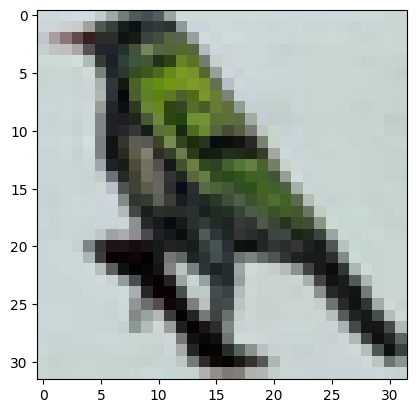

In [ ]:
def imgshow(image):
    image = image[0]
    image = image / 2 + 0.5
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))

    plt.imshow(image)
    

imgshow(image)


In [37]:
def visualize_attention_head(image, attentions, head_idx=0, layer_idx=0, patch_size=4):
    # 提取第layer_idx层、第head_idx头的注意力权重
    attn = attentions[layer_idx][0, head_idx]  # [seq_len+1, seq_len+1]
    
    # 移除[CLS] token的注意力（可选）
    attn = attn[0, 1:]  # [num_patches, num_patches]
    
    # 计算每个Patch的平均关注度
    attn_map = attn
    
    # 将注意力权重映射到图像尺寸
    h, w = image.shape[3] // patch_size, image.shape[2] // patch_size
    attn_map = attn_map.reshape(h, w)
    
    # 插值到原图尺寸
    attn_map = np.kron(attn_map, np.ones((patch_size, patch_size)))
    
    # 叠加到原图
    imgshow(image)
    plt.imshow(attn_map, alpha=0.5, cmap='viridis')
    plt.title(f"Layer {layer_idx}, Head {head_idx}")
    plt.axis('off')
    plt.show()

# 示例：可视化第0层、第0头的注意力
# visualize_attention_head(image, attentions, head_idx=1, layer_idx=4)



def visualize_attention_head_average(image, attentions, layer_idx=0, patch_size=4):
    # attentions: [layers, batches, num_heads, seq_len+1, seq_len+1]
    attn = attentions[layer_idx][0]
    num_heads = attn.shape[0]
    attn = attn.sum(axis=0) / num_heads
    

    attn_map = attn[0, 1:]

    
    # 将注意力权重映射到图像尺寸
    h, w = image.shape[3] // patch_size, image.shape[2] // patch_size
    attn_map = attn_map.reshape(h, w)
    
    # 插值到原图尺寸
    attn_map = np.kron(attn_map, np.ones((patch_size, patch_size)))
    
    # 叠加到原图
    imgshow(image)
    plt.imshow(attn_map, alpha=0.5, cmap='viridis')
    plt.title(f"Layer {layer_idx}")
    plt.axis('off')
    plt.show()

In [38]:
model_name = ["vit", "gaussian", "linear_2", "optimized_mhsa", "pseudo_mhsa"]

In [39]:
# fmt: off
config = OrderedDict(
    dataset="Cifar10",
    model="vit",
    load_checkpoint_file=None,
    no_cuda=False,

    # === OPTIMIZER ===
    optimizer_learning_rate=1e-3,
    optimizer_warmup_ratio=0.05,  # period of linear increase for lr scheduler
    optimizer_betas=(0.9, 0.95), 
    optimizer_weight_decay=1e-4,
    batch_size=100,
    num_epochs=800,
    seed=42,

    # === Encoder & Decoder ===
    encoder_model_dim = 256,
    encoder_layers = 6,

    decoder_model_dim = 128,
    decoder_layers = 6,
    droprate = 0.1,

    # === MHSA ===
    num_heads = 8,
    encoder_mlp_dim = 512,
    decoder_mlp_dim = 384,
    attn_droprate = 0,
    mlp_droprate = 0.1,
    
    # === Kark ===
    encoder_hidden_dim = 256,
    decoder_hidden_dim = 192,

    encoder_inner_ref_config = [None, "self"],
    decoder_inner_ref_config = [None, "self"],

    encoder_outer_ref_config = [None, "self"],
    decoder_outer_ref_config = [None, "self"],

    # === LOGGING ===
    only_list_parameters=False,
    num_keep_checkpoints=5,
    plot_attention_positions=False,
    output_dir="./output.tmp",
)


model_names = ["vit", "linear", "optimized_mhsa", "pseudo_mhsa", "linear", "gaussian"]
my_model = {}


for i in range(len(model_names)):
    model_name = model_names[i]
    config["model"] = model_name
    if model_name == "linear":
        path_name = model_name + "_2"
    else: path_name = model_name
    path = f"runs_finetune/{path_name}/final.checkpoint"

    if model_name == "gaussian":
        config["encoder_model_dim"] = 64
        config["encoder_mlp_dim"] = 256
        config["encoder_hidden_dim"] = 64
    else:
        config["encoder_model_dim"] = 256
        config["encoder_mlp_dim"] = 512
        config["encoder_hidden_dim"] = 256
    my_model[model_name] = Finetune_v(config)
    restore_checkpoint(path, my_model[model_name], device=torch.device("cpu"))
    my_model[model_name].eval()
    my_model[model_name](image)

Loading model parameters from 'runs_finetune/vit/final.checkpoint'
Loading model parameters from 'runs_finetune/linear_2/final.checkpoint'
Loading model parameters from 'runs_finetune/optimized_mhsa/final.checkpoint'
Loading model parameters from 'runs_finetune/pseudo_mhsa/final.checkpoint'
Loading model parameters from 'runs_finetune/linear_2/final.checkpoint'
Loading model parameters from 'runs_finetune/gaussian/final.checkpoint'


In [40]:
model_names = ["vit", "linear", "optimized_mhsa", "pseudo_mhsa", "linear", "gaussian"]
models_attentions = {}
for i in range(len(model_names)):
    model_name = model_names[i]
    attentions = my_model[model_name].encoder.attentions
    models_attentions[model_name] = attentions

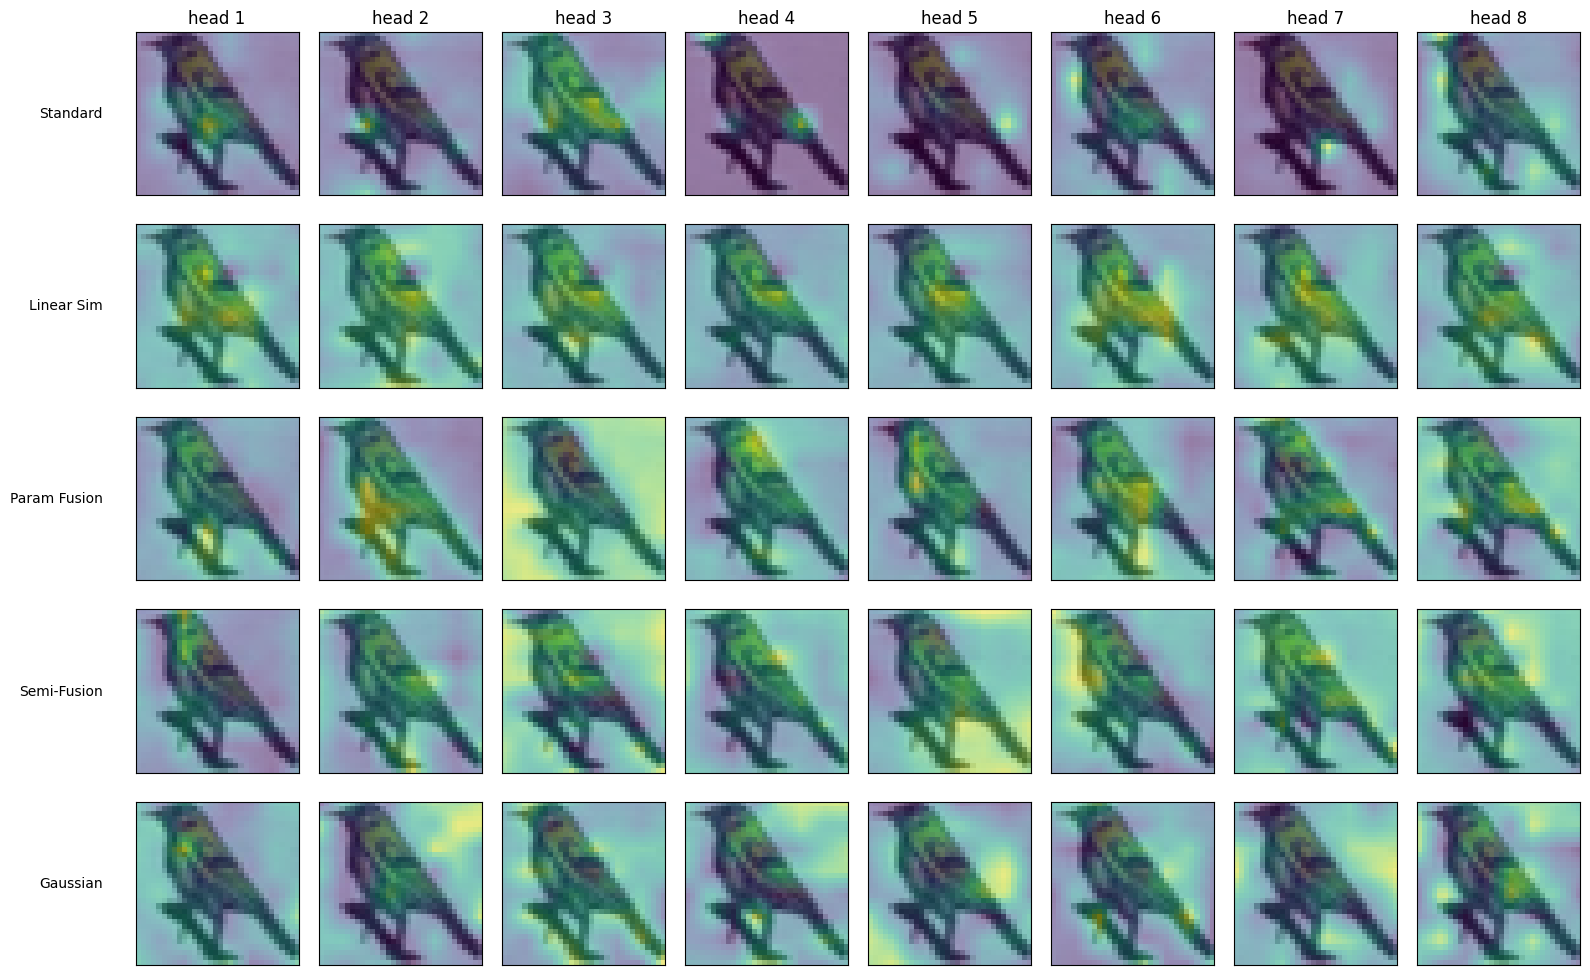

None


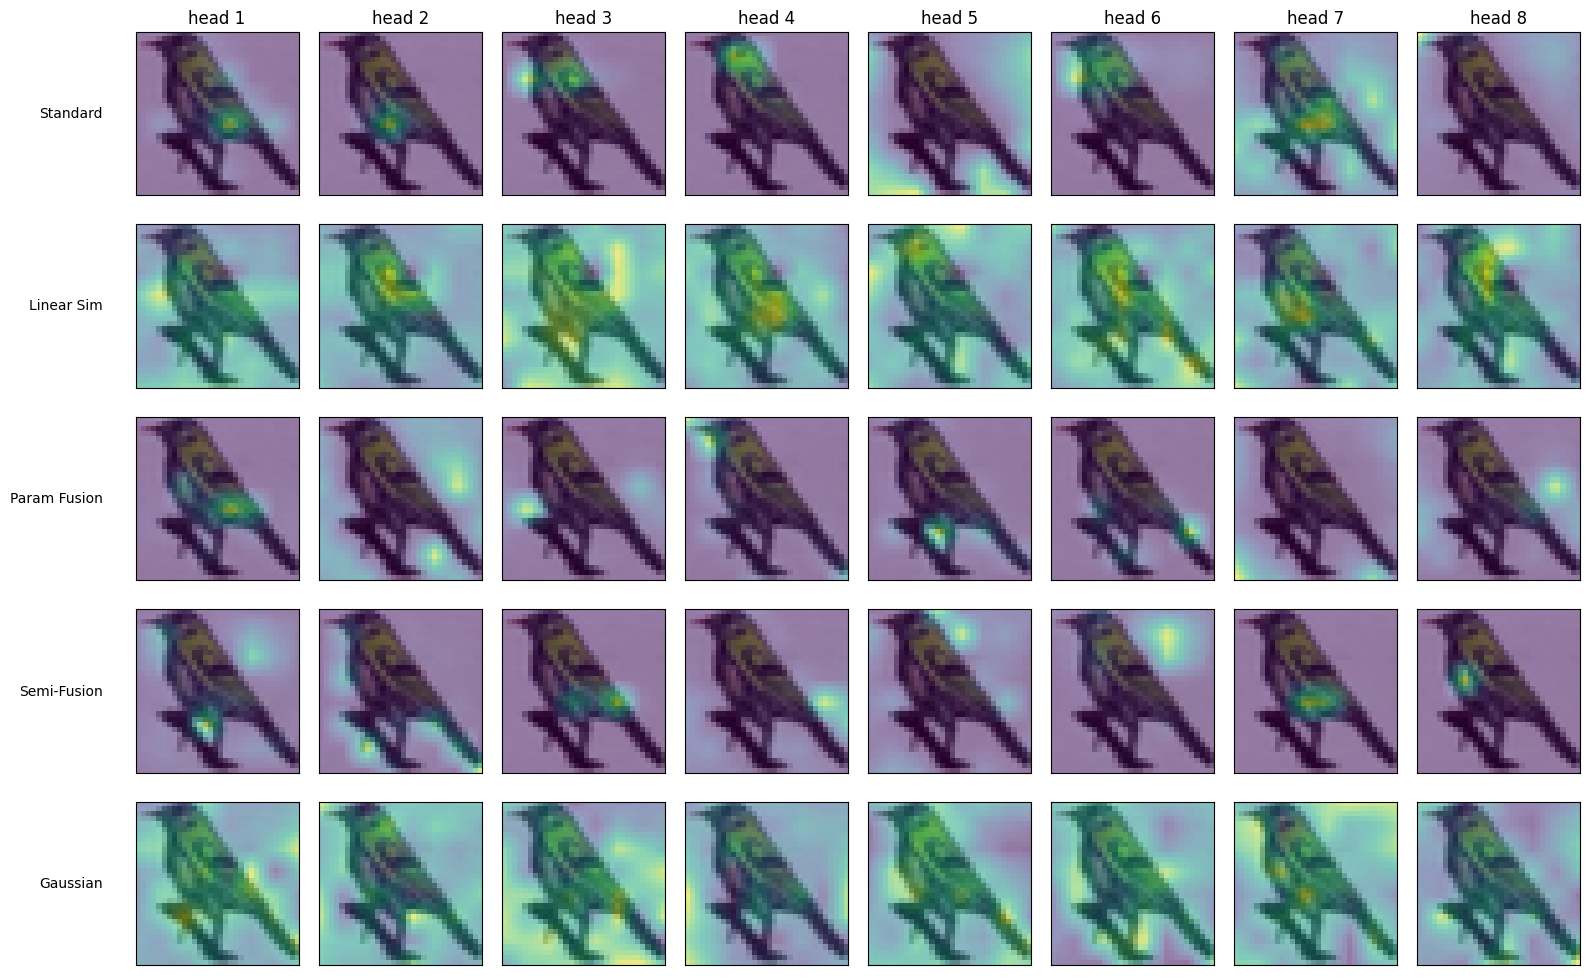

None


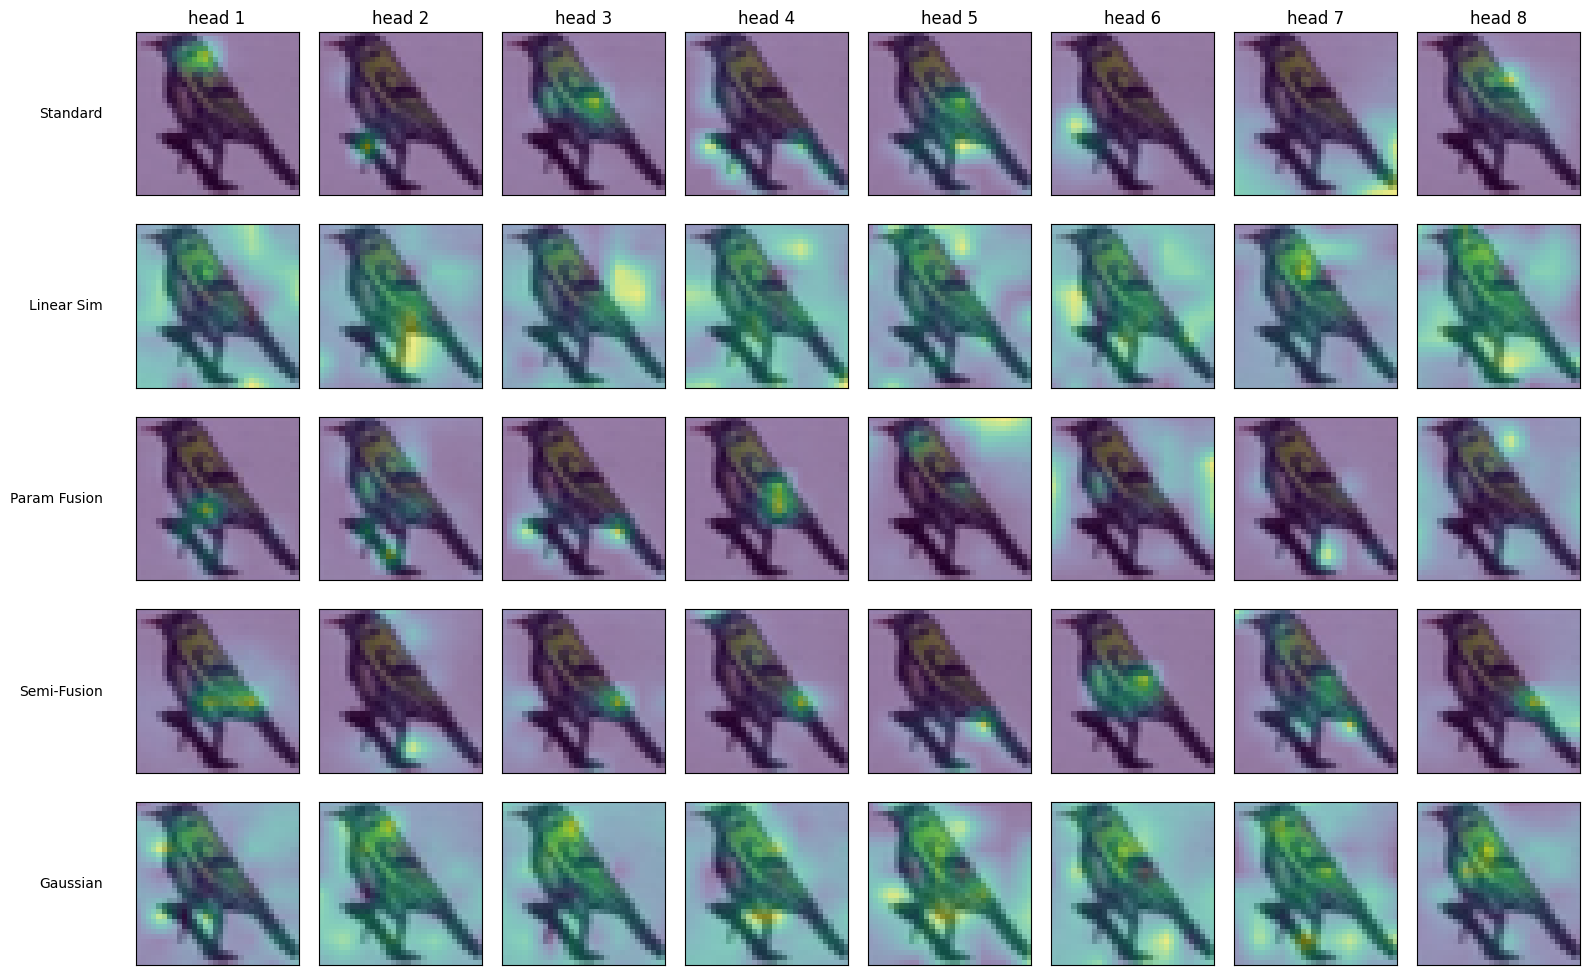

None


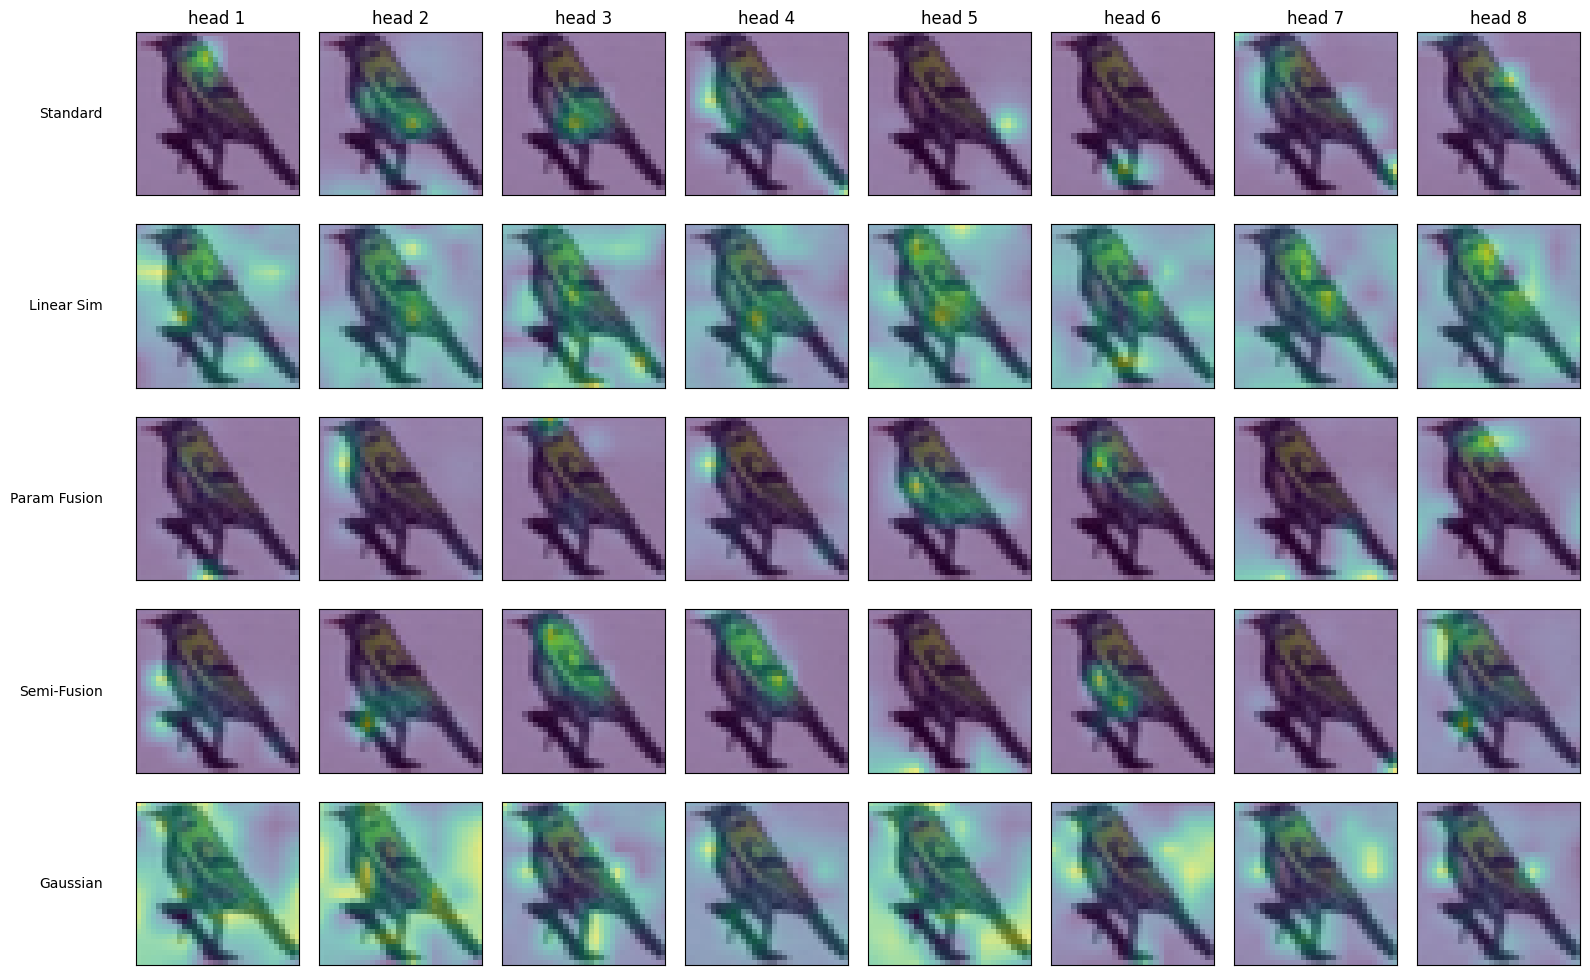

None


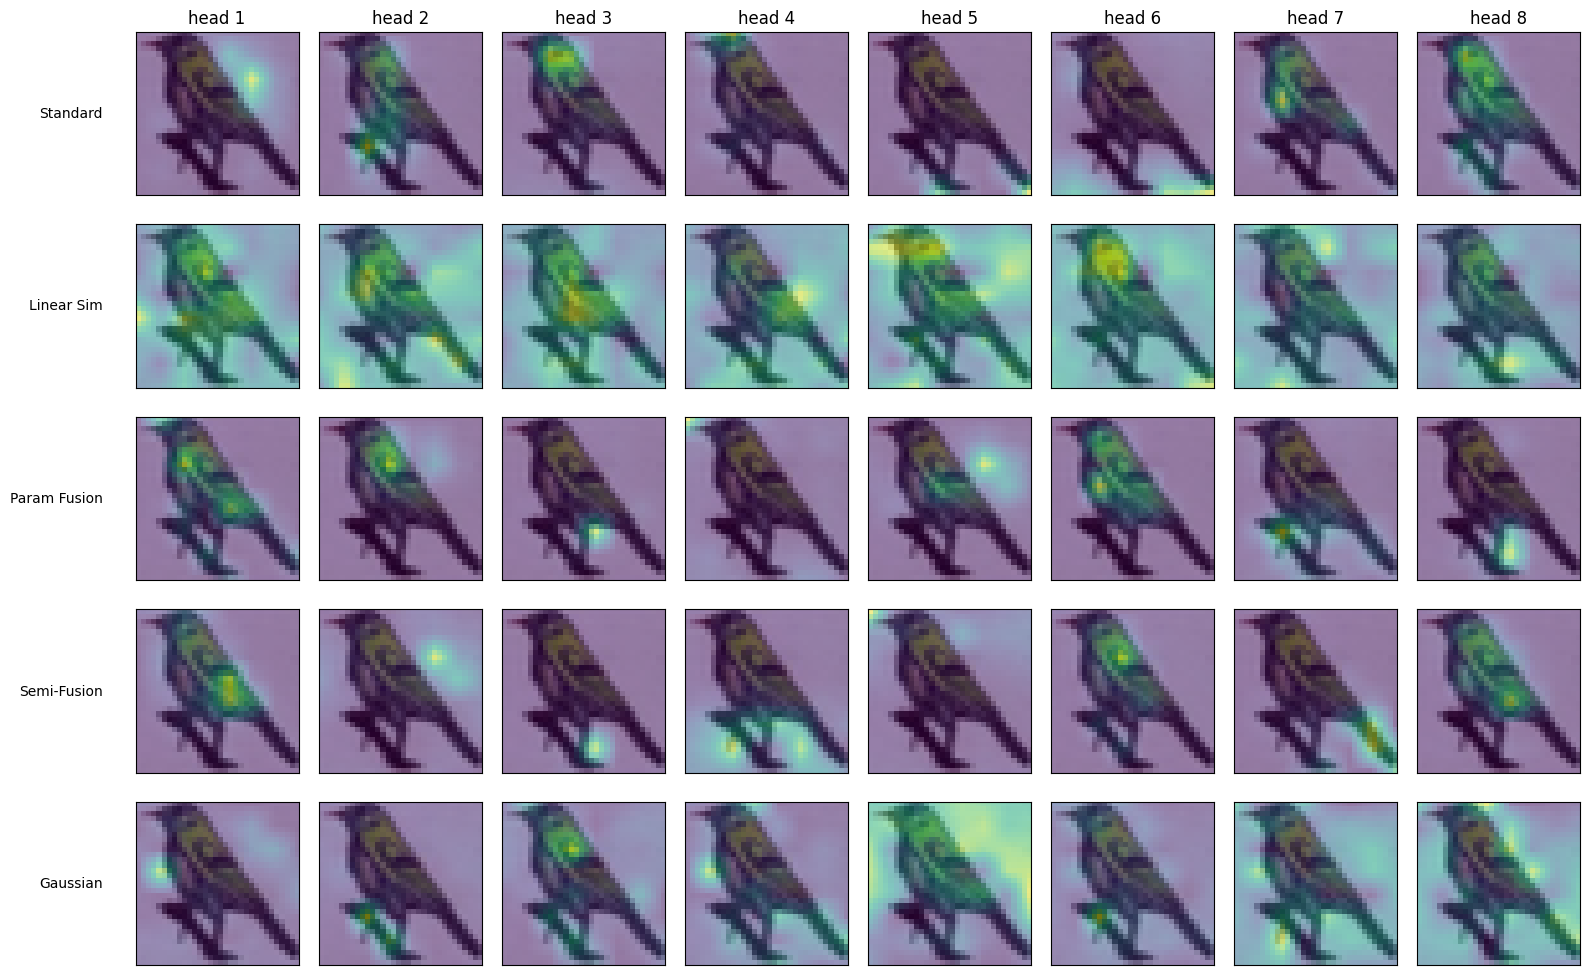

None


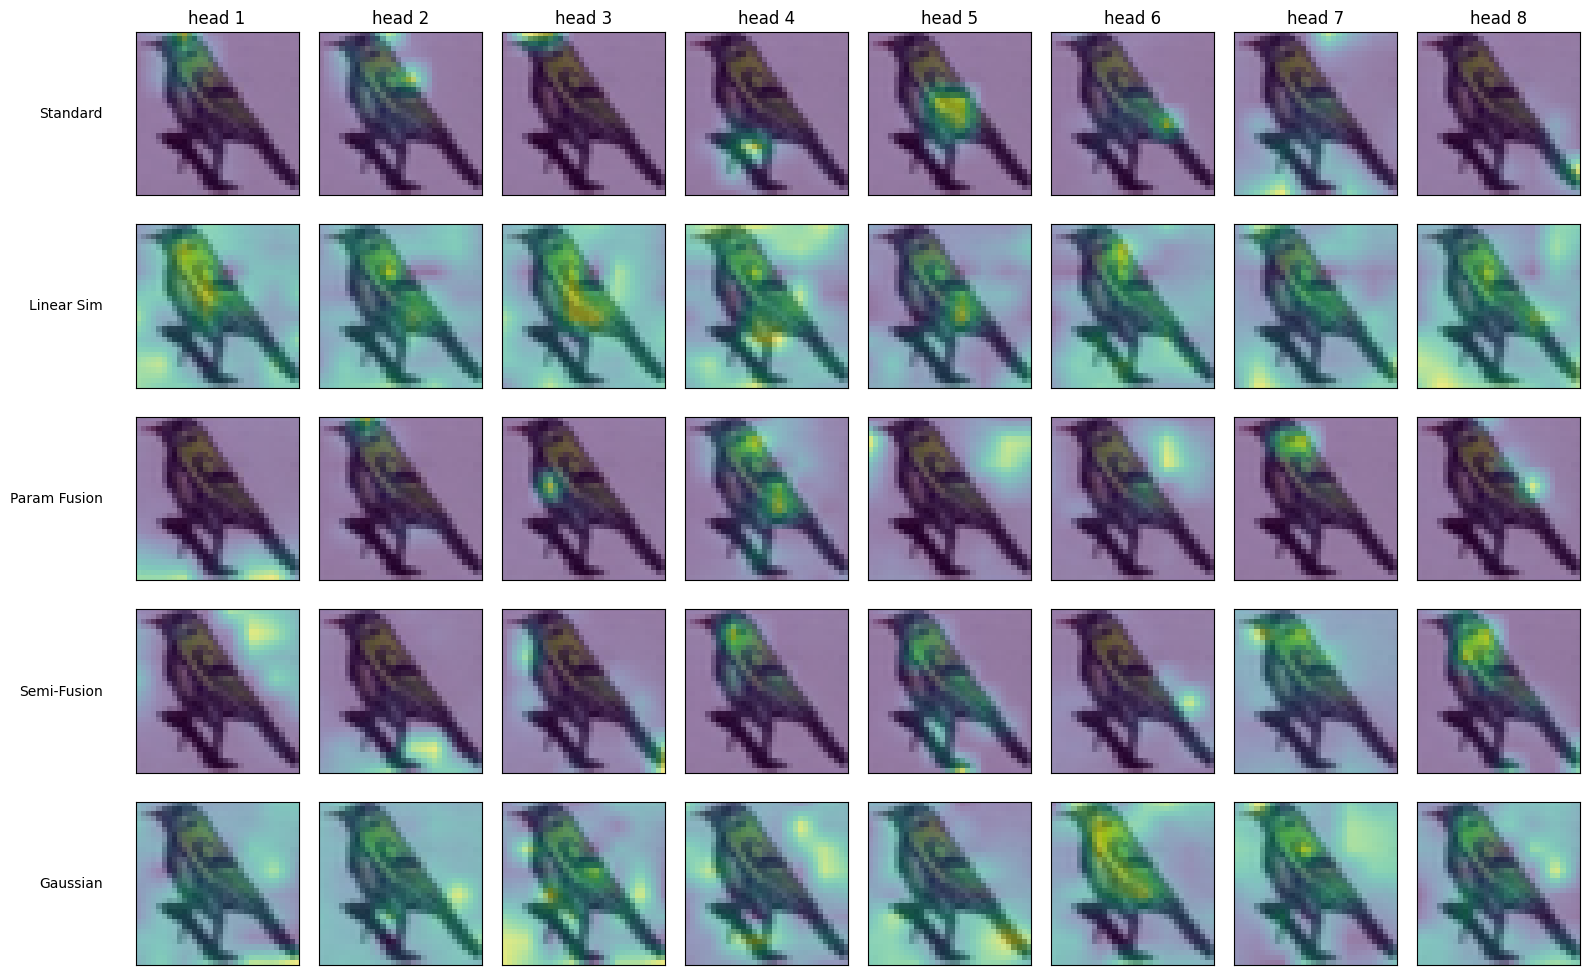

None


In [51]:
def visualize_multiple_models_heads(models_attentions, image, layer_idx, patch_size=4):
    """
    可视化多个模型各层的注意力图（独立颜色范围+双线性插值）
    
    参数：
    - models_attentions: Dict[str, Tensor] 
        模型名到注意力张量的映射，每个张量形状为 [layers, batch, heads, seq+1, seq+1]
    - image: torch.Tensor 
        输入图像，形状为 (1, 3, H, W)
    - patch_size: int 
        分块大小
    """
    # 基础参数
    english_labels = ["Standard", "Linear Sim", "Param Fusion", "Semi-Fusion", "Gaussian"]
    model_names = list(models_attentions.keys())
    num_models = len(model_names)
    num_heads = models_attentions[model_names[0]][0].shape[1]
    h, w = image.shape[-2], image.shape[-1]

    # 创建画布
    fig, axes = plt.subplots(
        num_models, 
        num_heads,
        figsize=(num_heads*2, num_models*2),
        squeeze=False
    )

    # 预处理原图
    img = image[0].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    # 遍历所有模型
    for row_idx, model_name in enumerate(model_names):
        attns = models_attentions[model_name][layer_idx]
        
        for col_idx in range(num_heads):
            current_label = english_labels[row_idx]
            ax = axes[row_idx, col_idx]
            
            # 提取注意力权重
            attn = attns[0][col_idx]  # [seq+1, seq+1]
            cls_attn = attn[0, 1:]
            
            # 生成热图 --------------------------------------------------------
            # 1. 转换为二维分块矩阵
            h_patches = h // patch_size
            w_patches = w // patch_size
            attn_2d = cls_attn.reshape(h_patches, w_patches)
            
            # 2. 使用双线性插值扩展到原图尺寸
            attn_map = zoom(
                attn_2d, 
                (patch_size, patch_size),  # 放大倍数
                order=1  # 1:双线性插值
            )
            # -------------------------------------------------------------
            
            # 可视化（独立颜色范围）
            ax.imshow(img)
            im = ax.imshow(
                attn_map, 
                alpha=0.5, 
                cmap='viridis',
                vmin=cls_attn.min(),  # 使用当前层独立范围
                vmax=cls_attn.max()
            )
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            # 添加标签
            if row_idx == 0:
                ax.set_title(f"head {col_idx+1}")
            if col_idx == 0:
                ax.set_ylabel(current_label, 
                            rotation=0, 
                            ha='right', 
                            va='center',
                            labelpad=20)

    plt.tight_layout()
    plt.show()

for i in range(6):
    print(visualize_multiple_models_heads(models_attentions, image, layer_idx=i, patch_size=4))

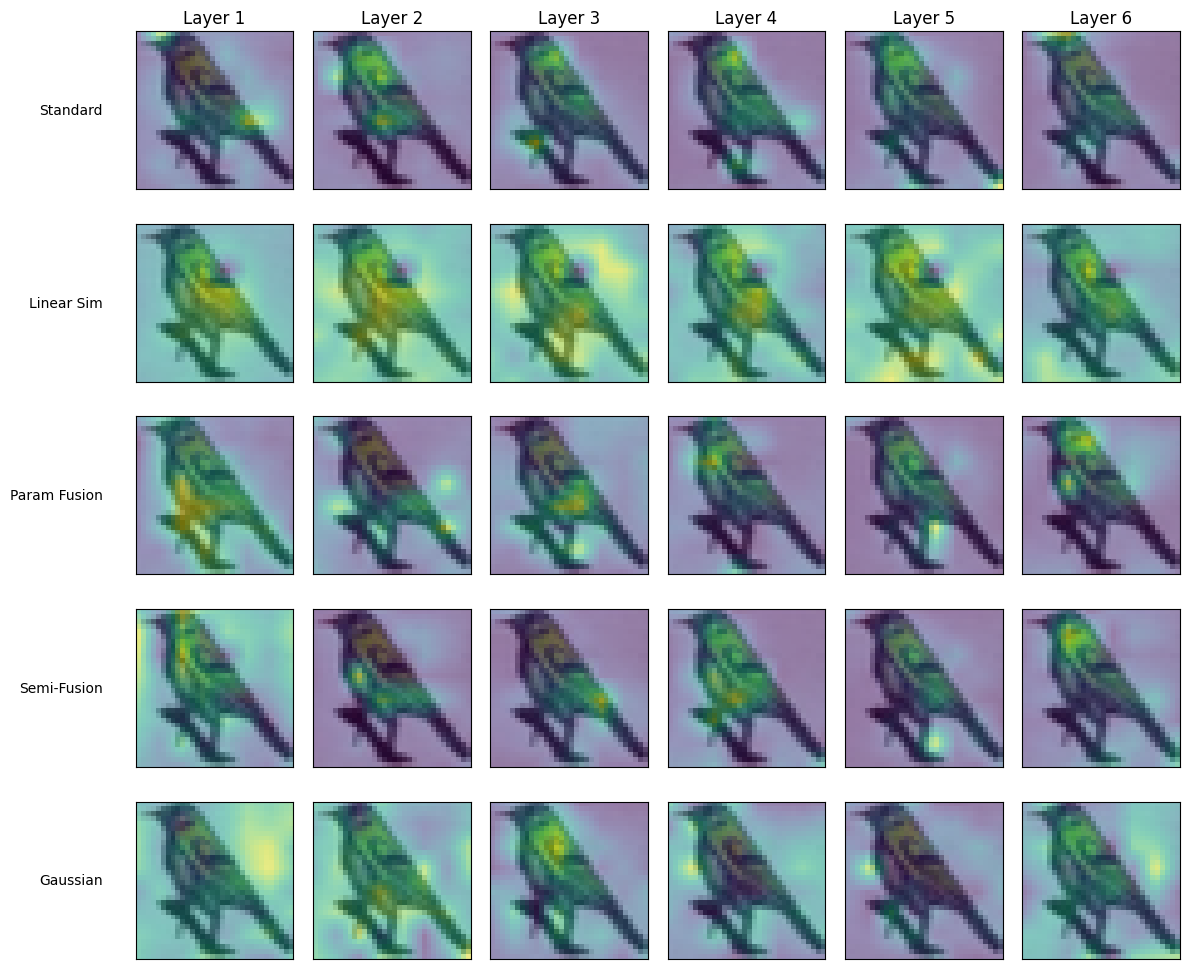

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

def visualize_multiple_models(models_attentions, image, patch_size=4):
    """
    Visualize attention maps across models and layers (Independent color ranges + Bilinear interpolation)
    
    Parameters:
    - models_attentions: Dict[str, Tensor] 
        Model name to attention tensor mapping, each tensor shape [layers, batch, heads, seq+1, seq+1]
    - image: torch.Tensor 
        Input image with shape (1, 3, H, W)
    - patch_size: int 
        Patch size
    """
    # Define English labels (order must match input dict keys)
    english_labels = ["Standard", "Linear Sim", "Param Fusion", "Semi-Fusion", "Gaussian"]
    
    # Base parameters
    model_names = list(models_attentions.keys())
    num_models = len(model_names)
    num_layers = len(models_attentions[model_names[0]])
    h, w = image.shape[-2], image.shape[-1]

    # Create figure
    fig, axes = plt.subplots(
        num_models, 
        num_layers,
        figsize=(num_layers*2, num_models*2),
        squeeze=False
    )

    # Preprocess image
    img = image[0].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    # Iterate through models
    for row_idx, model_name in enumerate(model_names):
        attns = models_attentions[model_name]
        
        # Get corresponding English label
        current_label = english_labels[row_idx]
        
        for col_idx in range(num_layers):
            ax = axes[row_idx, col_idx]
            
            # Extract attention weights
            attn = attns[col_idx][0].mean(0)  # [seq+1, seq+1]
            cls_attn = attn[0, 1:]
            
            # Generate heatmap
            h_patches = h // patch_size
            w_patches = w // patch_size
            attn_2d = cls_attn.reshape(h_patches, w_patches)
            attn_map = zoom(attn_2d, (patch_size, patch_size), order=1)
            
            # Visualization
            ax.imshow(img)
            im = ax.imshow(
                attn_map, 
                alpha=0.5, 
                cmap='viridis',
                vmin=cls_attn.min(),
                vmax=cls_attn.max()
            )
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Set labels
            if row_idx == 0:
                ax.set_title(f"Layer {col_idx+1}")
            if col_idx == 0:
                ax.set_ylabel(current_label, 
                            rotation=0, 
                            ha='right', 
                            va='center',
                            labelpad=20,
                            fontsize=10)

    plt.tight_layout()
    plt.show()

# Usage example
visualize_multiple_models(models_attentions, image, patch_size=4)